0
Epoch[1/30], step[1/782], Loss: 0.2041
Epoch[1/30], step[101/782], Loss: 0.1019
Epoch[1/30], step[201/782], Loss: 0.0883
Epoch[1/30], step[301/782], Loss: 0.0831
Epoch[1/30], step[401/782], Loss: 0.0831
Epoch[1/30], step[501/782], Loss: 0.0780
Epoch[1/30], step[601/782], Loss: 0.0723
Epoch[1/30], step[701/782], Loss: 0.0678
Epoch[2/30], step[1/782], Loss: 0.0692
Epoch[2/30], step[101/782], Loss: 0.0679
Epoch[2/30], step[201/782], Loss: 0.0713
Epoch[2/30], step[301/782], Loss: 0.0621
Epoch[2/30], step[401/782], Loss: 0.0625
Epoch[2/30], step[501/782], Loss: 0.0709
Epoch[2/30], step[601/782], Loss: 0.0662
Epoch[2/30], step[701/782], Loss: 0.0642
Epoch[3/30], step[1/782], Loss: 0.0622
Epoch[3/30], step[101/782], Loss: 0.0665
Epoch[3/30], step[201/782], Loss: 0.0634
Epoch[3/30], step[301/782], Loss: 0.0626
Epoch[3/30], step[401/782], Loss: 0.0590
Epoch[3/30], step[501/782], Loss: 0.0619
Epoch[3/30], step[601/782], Loss: 0.0646
Epoch[3/30], step[701/782], Loss: 0.0599
Epoch[4/30], step[1/

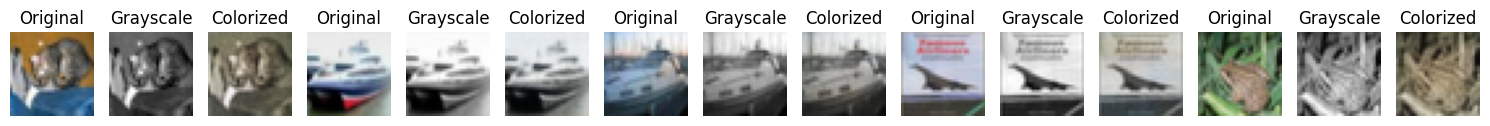


Visualizing CIFAR-10 examples with Exaggerated Colors:


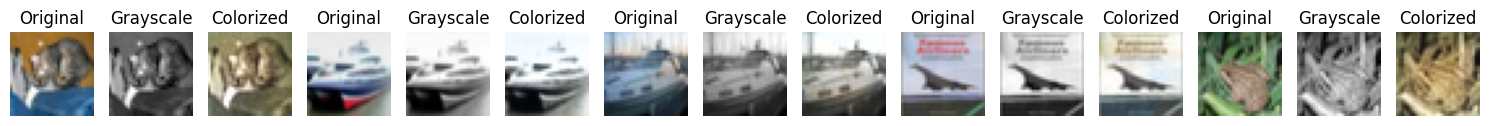

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
from google.colab import files # For Google Colab specific upload

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print(torch.cuda.current_device())
else:
    print("No NVDIA driver found using CPU")

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.CIFAR10(root='./data' ,train=True,download=True,transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=64,shuffle=True,num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root = './data',train=False,download=True,transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=64,shuffle=False,num_workers=2)

# --- UPDATED MODEL ARCHITECTURE (More Capacity) ---
class ColorizationNet(nn.Module):
    def __init__(self):
        super(ColorizationNet, self).__init__()
        # Encoder
        self.enc_conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1) # (1, 32, 32) -> (32, 16, 16)
        self.enc_conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1) # (32, 16, 16) -> (64, 8, 8)
        self.enc_conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1) # (64, 8, 8) -> (128, 4, 4)

        # Decoder (using ConvTranspose2d for upsampling)
        self.dec_conv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1) # (128, 4, 4) -> (64, 8, 8)
        self.dec_conv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1) # (64, 8, 8) -> (32, 16, 16)
        self.dec_conv3 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1) # (32, 16, 16) -> (3, 32, 32)

    def forward(self, x):
        # Encoder path
        e1 = nn.functional.relu(self.enc_conv1(x))
        e2 = nn.functional.relu(self.enc_conv2(e1))
        e3 = nn.functional.relu(self.enc_conv3(e2))

        # Decoder path
        d1 = nn.functional.relu(self.dec_conv1(e3))
        d2 = nn.functional.relu(self.dec_conv2(d1))
        # Final layer with sigmoid for [0, 1] output
        output = torch.sigmoid(self.dec_conv3(d2))
        return output

model= ColorizationNet().to(device)

# --- CHANGED LOSS FUNCTION ---
criterion = nn.L1Loss() # Using L1 Loss instead of MSE Loss
optimizer = optim.Adam(model.parameters(), lr = 0.001)

def rgb_to_gray(img):
    return img[:, 0:1, :, :] * 0.299 + img[:, 1:2, :, :] * 0.587 + img[:, 2:3, :, :] * 0.114

EPOCHS = 30 # Increased epochs for better training, you can go higher (e.g., 100)
for epoch in range (EPOCHS):
    for i,(images,_) in enumerate(train_loader):
        grayscale_images = rgb_to_gray(images).to(device)
        images = images.to(device)
        outputs = model(grayscale_images)
        loss = criterion(outputs,images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 100 == 0 :
            print (f"Epoch[{epoch+1}/{EPOCHS}], step[{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

print("Finished_Training")

# --- CORRECTED imshow FUNCTION ---
def imshow(img):
    # This function expects a torch.Tensor or numpy array in [0, 1]
    # No unnormalization is needed if data is already in [0, 1]
    if isinstance(img, Image.Image):
        npimg = np.array(img)
    elif torch.is_tensor(img):
        npimg = img.numpy()
    else:
        npimg = img # Assume it's already a numpy array

    # Handle grayscale images (1 channel or 2D)
    if len(npimg.shape) == 2 or (len(npimg.shape) == 3 and npimg.shape[0] == 1):
        if len(npimg.shape) == 3: # If it's (1, H, W)
            npimg = npimg.squeeze(0)
        plt.imshow(npimg, cmap='gray')
    # Handle RGB/RGBA images (3 or 4 channels)
    elif len(npimg.shape) == 3 and (npimg.shape[0] == 3 or npimg.shape[0] == 4):
        # Transpose from (C, H, W) to (H, W, C) for matplotlib
        if npimg.shape[0] in [3, 4]: # Check if channel-first
            npimg = np.transpose(npimg, (1, 2, 0))
        plt.imshow(npimg) # Matplotlib handles [0,1] or [0,255] automatically
    else:
        print(f"Warning: Unexpected image shape for imshow: {npimg.shape}")
        plt.imshow(npimg) # Attempt to show anyway

def visualize_all_three(original_images, grayscale_images, colorized_images, n=5):
    fig = plt.figure(figsize=(3 * n, 4))
    for i in range(n):
        ax = plt.subplot(1, 3 * n, 3 * i + 1)
        imshow(original_images[i].cpu())
        ax.set_title("Original")
        ax.axis("off")

        ax = plt.subplot(1, 3 * n, 3 * i + 2)
        imshow(grayscale_images[i].cpu())
        ax.set_title("Grayscale")
        ax.axis("off")

        ax = plt.subplot(1, 3 * n, 3 * i + 3)
        imshow(colorized_images[i].cpu())
        ax.set_title("Colorized")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

def torch_rgb_to_hsv(rgb):
    r, g, b = rgb[:, 0, :, :], rgb[:, 1, :, :], rgb[:, 2, :, :]
    max_val = torch.max(rgb, dim=1).values
    min_val = torch.min(rgb, dim=1).values
    h = torch.zeros_like(max_val)
    delta = max_val - min_val
    s = torch.where(max_val == 0, torch.zeros_like(max_val), delta / max_val)

    h[max_val == min_val] = 0
    h[max_val == r] = (60 * ((g - b) / delta))[max_val == r] % 360
    h[max_val == g] = (60 * ((b - r) / delta) + 120)[max_val == g]
    h[max_val == b] = (60 * ((r - g) / delta) + 240)[max_val == b]

    h = h / 360.0 # Normalize H to [0, 1]
    v = max_val
    return torch.stack([h, s, v], dim=1)

def torch_hsv_to_rgb(hsv):
    h, s, v = hsv[:, 0, :, :], hsv[:, 1, :, :], hsv[:, 2, :, :]
    i = (h * 6.0).floor()
    f = h * 6.0 - i
    p = v * (1.0 - s)
    q = v * (1.0 - s * f)
    t = v * (1.0 - s * (1.0 - f))

    i_mod = (i % 6).long()

    r = torch.zeros_like(h)
    g = torch.zeros_like(h)
    b = torch.zeros_like(h)

    mask_0 = (i_mod == 0)
    r[mask_0] = v[mask_0]
    g[mask_0] = t[mask_0]
    b[mask_0] = p[mask_0]

    mask_1 = (i_mod == 1)
    r[mask_1] = q[mask_1]
    g[mask_1] = v[mask_1]
    b[mask_1] = p[mask_1]

    mask_2 = (i_mod == 2)
    r[mask_2] = p[mask_2]
    g[mask_2] = v[mask_2]
    b[mask_2] = t[mask_2]

    mask_3 = (i_mod == 3)
    r[mask_3] = p[mask_3]
    g[mask_3] = q[mask_3]
    b[mask_3] = v[mask_3]

    mask_4 = (i_mod == 4)
    r[mask_4] = t[mask_4]
    g[mask_4] = p[mask_4]
    b[mask_4] = v[mask_4]

    mask_5 = (i_mod == 5)
    r[mask_5] = v[mask_5]
    g[mask_5] = p[mask_5]
    b[mask_5] = q[mask_5]

    return torch.stack([r, g, b], dim=1)

def exaggerate_colors(images, saturation_factor=1.5, value_factor=1.2):
    images_hsv = torch_rgb_to_hsv(images)
    images_hsv[:, 1, :, :] = torch.clamp(images_hsv[:, 1, :, :] * saturation_factor, 0, 1)
    images_hsv[:, 2, :, :] = torch.clamp(images_hsv[:, 2, :, :] * value_factor, 0, 1)
    color_exaggerated_images = torch_hsv_to_rgb(images_hsv)
    return color_exaggerated_images

# --- Visualization from CIFAR-10 ---
model.eval()
with torch.no_grad():
    dataiter = iter(test_loader)
    images, labels = next(dataiter)

    original_images_to_show = images[:5]
    grayscale_images_to_show = rgb_to_gray(original_images_to_show).to(device)
    colorized_outputs = model(grayscale_images_to_show).cpu()

    exaggerated_colorized_outputs = exaggerate_colors(colorized_outputs)

    print("Visualizing CIFAR-10 examples:")
    visualize_all_three(original_images_to_show, grayscale_images_to_show.cpu(), colorized_outputs, n=5)

    print("\nVisualizing CIFAR-10 examples with Exaggerated Colors:")
    visualize_all_three(original_images_to_show, grayscale_images_to_show.cpu(), exaggerated_colorized_outputs, n=5)



In [7]:
# --- Uploading a custom image (Google Colab specific) ---
print("\n--- Uploading custom image ---")
uploaded = files.upload() # This will open a file upload dialog



--- Uploading custom image ---


Saving butterfly.png to butterfly (4).png
Saving butterfly_colored.png to butterfly_colored (3).png
Saving butterfly_grayscale.png to butterfly_grayscale (3).png


In [8]:
import os

# List files in the current directory
print("Files in /content/:")
for f in os.listdir('/content/'):
    print(f)

# Or more directly check if the file exists
if os.path.exists('butterfly.png'):
    print("\n'butterfly.png' IS found in the current directory.")
else:
    print("\n'butterfly.png' is NOT found in the current directory.")
    print("Please ensure the uploaded file is named exactly 'butterfly.png'.")

Files in /content/:
.config
butterfly_grayscale.png
butterfly (4).png
butterfly_colored (1).png
butterfly_colored (2).png
butterfly (1).png
butterfly_grayscale (2).png
butterfly_grayscale (3).png
butterfly (2).png
butterfly_colored (3).png
color butterfly.png
data
butterfly.png
butterfly (3).png
butterfly_colored.png
butterfly_grayscale (1).png
sample_data

'butterfly.png' IS found in the current directory.


Looking for color image, found: butterfly (4).png
Looking for color image, found: butterfly_colored (3).png
Successfully opened butterfly_colored (3).png as a color image.


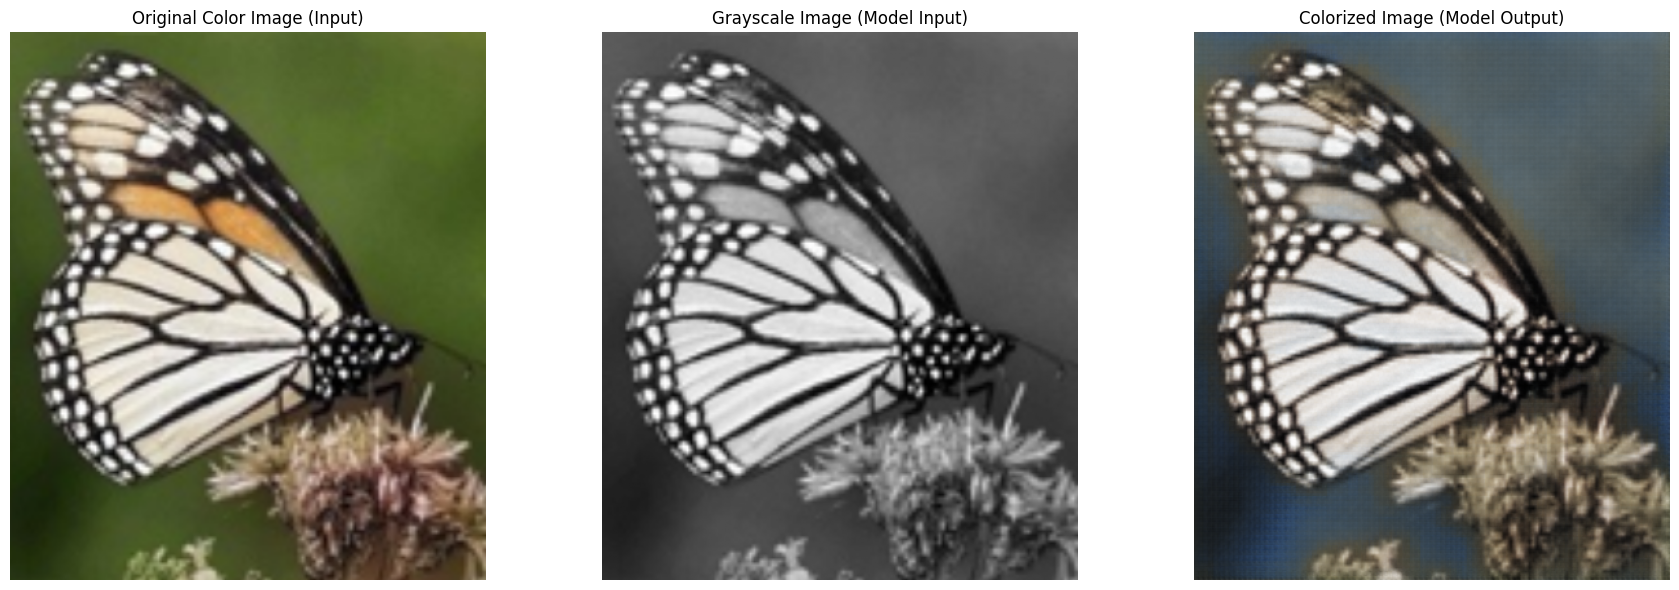

Saved colorized_uploaded_butterfly.png


In [11]:
uploaded_filename = None
for filename in uploaded.keys():
    print("Looking for color image, found:", filename)
    # Change the condition to look for the actual name of your color image
    if "butterfly_colored (3).png" == filename: # Exact match
        uploaded_filename = filename
        break
    # Or, if you want to be a bit more flexible with numbering but ensure it's "colored"
    # if "butterfly_colored" in filename and filename.endswith(".png"):
    #     uploaded_filename = filename
    #     break

if uploaded_filename is None:
    print("Error: The specific color image was not found. Please ensure 'butterfly_colored (3).png' is uploaded.")
else:
    try:
        # Ensure the uploaded image is a color image (RGB or RGBA)
        img_original_color = Image.open(uploaded_filename).convert("RGB") # Use the variable
        print(f"Successfully opened {uploaded_filename} as a color image.")
    except Exception as e:
        print(f"Error opening or converting {uploaded_filename}: {e}") # Use the variable
        print("Please ensure you upload a valid image file.")
        img_original_color = None

    if img_original_color:
        # ... (rest of your existing code for processing and displaying) ...
        # Create grayscale version for model input
        gray_img_for_model = img_original_color.convert("L")

        # Prepare for model: PIL Image -> Tensor (1, C, H, W)
        transform_for_single_image = transforms.Compose([transforms.ToTensor()])
        img_tensor_for_model = transform_for_single_image(gray_img_for_model).unsqueeze(0) # Add batch dimension

        model.eval()
        img_tensor_for_model = img_tensor_for_model.to(device)

        with torch.no_grad():
            colorized_tensor = model(img_tensor_for_model)

        # Convert output tensor back to PIL Image
        colorized_img_pil = transforms.ToPILImage()(colorized_tensor.squeeze(0).cpu())

        # --- Display the custom image results ---
        fig, ax = plt.subplots(1, 3, figsize=(18, 6))

        ax[0].imshow(img_original_color)
        ax[0].set_title("Original Color Image (Input)")
        ax[0].axis('off')

        ax[1].imshow(gray_img_for_model, cmap='gray')
        ax[1].set_title("Grayscale Image (Model Input)")
        ax[1].axis('off')

        ax[2].imshow(colorized_img_pil)
        ax[2].set_title("Colorized Image (Model Output)")
        ax[2].axis('off')

        plt.tight_layout()
        plt.show()

        colorized_img_pil.save("colorized_uploaded_butterfly.png")
        print("Saved colorized_uploaded_butterfly.png")